<a href="https://colab.research.google.com/github/benmsanderson/scenariopca/blob/main/pyam_scenario_PCA_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install Stuff

In [12]:
!git clone https://github.com/znicholls/pyam.git

fatal: destination path 'pyam' already exists and is not an empty directory.


In [13]:
import os

path = "pyam"

# Check current working directory.
retval = os.getcwd()

# Now change the directory
os.chdir( path )

In [14]:
!git checkout 'read-ar6'

Already on 'read-ar6'
Your branch is up to date with 'origin/read-ar6'.


In [15]:
pip install --editable .[tests,optional_io_formats,tutorials]

Obtaining file:///content/pyam/pyam
ERROR: file:///content/pyam/pyam does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [16]:
#!pip install -q pyam-iamc
!pip install -q unfccc-di-api
!pip install eofs
!pip install corner
!pip install fsspec

In [17]:
import pandas as pd
#pyam = __import__("pyam-iamc")
import pyam as pyam
#import src.pyam_iamc as pyam
#import fsspec
import pkg_resources
#pkg_resources.require("Pandas==1.0.5")
import unfccc_di_api

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import re
import sys
from eofs.multivariate.standard import MultivariateEof
import corner as corner


#Connect to IAM database

In [18]:


conn = pyam.iiasa.Connection()
conn.valid_connections


['ngfs_phase_3',
 'iamc15',
 'integration-test',
 'cdlinks',
 'india_scenario_hub',
 'genie',
 'hotspots',
 'commit',
 'kopernikus_public',
 'nexus-basins',
 'ngfs_phase_4',
 'senses',
 'aqnea',
 'navigate',
 'climate_solutions',
 'eu-climate-advisory-board',
 'engage',
 'nca5',
 'openentrance',
 'ar6-public',
 'deeds',
 'ngfs_phase_2',
 'gei',
 'netzero2040',
 'ripples',
 'ssp',
 'ecemf',
 'set_nav',
 'cmin',
 'ariadne',
 'paris_lttg']

In [19]:
conn = pyam.iiasa.Connection('ar6-public')

In [20]:
conn.scenarios()

0                                1
1                EN_INDCi2030_1000
2                EN_INDCi2030_500f
3                EN_INDCi2030_600f
4                EN_INDCi2030_700f
                   ...            
1384              SSP2_SPA2_19I_RE
1385       Directed Transition 1.0
1386                     2C-hybrid
1387    DISCRATE_cb600_cdrall_dr4p
1388                      SSP2_5.0
Name: scenario, Length: 1389, dtype: object

In [21]:
conn.regions().head()

0                    World
1    Sao Tome and Principe
2             Turkmenistan
3             Saint Helena
4                Lithuania
Name: region, dtype: object

#Query database

Search for fields

In [24]:
 #pd.set_option('display.max_colwidth', -1)
 vars=conn.variables()



In [51]:
vars[vars.str.contains("Policy Cost")]

1190    Policy Cost|Additional Total Energy System Cost
1191                   Policy Cost|Area under MAC Curve
1192                       Policy Cost|Consumption Loss
1193                        Policy Cost|Default for CAV
1194                   Policy Cost|Equivalent Variation
1195                               Policy Cost|GDP Loss
1196                 Policy Cost|GDP Loss|w/o transfers
1197                                  Policy Cost|Other
1198                              Policy Cost|Transfers
1199                         Policy Cost|Welfare Change
Name: variable, dtype: object

Construct Dataframe

In [26]:

df = conn.query(
    model='*',
    variable=['Carbon Sequestration|Land Use','Carbon Sequestration|CCS','Primary Energy|Nuclear', 'Primary Energy|Oil','Primary Energy|Gas','Primary Energy|Fossil','Primary Energy|Coal','Emissions|CO2|Energy and Industrial Processes','Emissions|CO2|AFOLU','Emissions|CH4','Emissions|N2O','Primary Energy|Non-Biomass Renewables','Primary Energy|Biomass','Final Energy'],
    region='World'
)

vs = [element.split('|')[-1:][0] for element in df.variable]
shv = {vs[i]: df.variable[i] for i in range(len(vs))}


In [27]:
df.meta

version Regional_scope  \
model                 scenario                                               
AIM/CGE 2.0           ADVANCE_2020_1.5C-2100            5.0         Global   
                      ADVANCE_2020_Med2C                4.0         Global   
                      ADVANCE_2020_WB2C                 4.0         Global   
                      ADVANCE_2030_Med2C                4.0         Global   
                      ADVANCE_2030_Price1.5C            4.0         Global   
...                                                     ...            ...   
GCAM 5.3              NGFS2_Below 2?C                   NaN            NaN   
MESSAGEix-GLOBIOM_1.1 NGFS2_Below 2?C                   NaN            NaN   
REMIND-MAgPIE 2.1-4.2 NGFS2_Below 2?C                   NaN            NaN   
                      NGFS2_Below 2?C - IPD-95th        NaN            NaN   
                      NGFS2_Below 2?C - IPD-median      NaN            NaN   

                                                          Category  \
model                 scenario                                       
AIM/CGE 2.0           ADVANCE_2020_1.5C-2100        failed-vetting   
                      ADVANCE_2020_Med2C            failed-vetting   
                      ADVANCE_2020_WB2C             failed-vetting   
                      ADVANCE_2030_Med2C            failed-vetting   
                      ADVANCE_2030_Price1.5C        failed-vetting   
...                                                            ...   
GCAM 5.3              NGFS2_Below 2?C                          NaN   
MESSAGEix-GLOBIOM_1.1 NGFS2_Below 2?C                          NaN   
REMIND-MAgPIE 2.1-4.2 NGFS2_Below 2?C                          NaN   
                      NGFS2_Below 2?C - IPD-95th               NaN   
                      NGFS2_Below 2?C - IPD-median             NaN   

                                                     Category_name  \
model                 scenario                                       
AIM/CGE 2.0           ADVANCE_2020_1.5C-2100        failed-vetting   
                      ADVANCE_2020_Med2C            failed-vetting   
                      ADVANCE_2020_WB2C             failed-vetting   
                      ADVANCE_2030_Med2C            failed-vetting   
                      ADVANCE_2030_Price1.5C        failed-vetting   
...                                                            ...   
GCAM 5.3              NGFS2_Below 2?C                          NaN   
MESSAGEix-GLOBIOM_1.1 NGFS2_Below 2?C                          NaN   
REMIND-MAgPIE 2.1-4.2 NGFS2_Below 2?C                          NaN   
                      NGFS2_Below 2?C - IPD-95th               NaN   
                      NGFS2_Below 2?C - IPD-median             NaN   

                                                    CO2 emissions reductions 2019-2020 % modelled Native  \
model                 scenario                                                                             
AIM/CGE 2.0           ADVANCE_2020_1.5C-2100                                                -1.215971      
                      ADVANCE_2020_Med2C                                                    -1.236740      
                      ADVANCE_2020_WB2C                                                     -1.236740      
                      ADVANCE_2030_Med2C                                                    -1.248593      
                      ADVANCE_2030_Price1.5C                                                -1.287815      
...                                                                                               ...      
GCAM 5.3              NGFS2_Below 2?C                                                             NaN      
MESSAGEix-GLOBIOM_1.1 NGFS2_Below 2?C                                                             NaN      
REMIND-MAgPIE 2.1-4.2 NGFS2_Below 2?C                                                             NaN      
                      NGFS2

In [28]:
years=np.arange(2010,2110,10)

#Define functions

Pivot table

In [29]:
def pivtab(x,catg='*'):
  tb={}
  itmp=[]

  for vrb in vs:
    print(vrb)
    filtb=x.filter(variable=shv[vrb],Category=catg).data
    unt=filtb.unit.unique()

    tmp=pd.pivot_table(filtb,index=['model','scenario'],columns='year',values=['value'])['value'][years]
    unt=unt[0][:]
    tb[vrb]=tmp
    tb[vrb].unit=unt
    itmp.append(tmp.index)
  ii=tb[list(tb)[0]].index
  for ij,vrb in enumerate(vs):
    ii=ii.intersection(itmp[ij])
  for vrb in vs:
    unt=tb[vrb].unit
    tb[vrb]=tb[vrb].loc[ii]
    tb[vrb].unit=unt
    tb[vrb].name=shv[vrb]
  return tb

In [30]:
df.meta.Category.unique()

array(['failed-vetting', 'C3', 'C5', 'C6', 'C7', 'C4', 'C1',
       'no-climate-assessment', 'C2', 'C8', nan], dtype=object)

Simple plots


In [31]:
def plt2d(x,y,t1=2050,t2=2050):
  if len(sys.argv) > 3:
    t2 = sys.argv[3]
  else:
    t2=t1
  p1=plt.scatter(tb[x][t1],tb[y][t2])
  plt.ylabel(shv[x]+' '+tb[x].unit)
  plt.xlabel(shv[y]+' '+tb[y].unit)
  plt.title(x+' '+str(t1)+' vs '+y+' '+ str(t2))
  return p1

In [32]:
def plt1d(x):
  p1=tb[x].T.plot(legend=False,color='lightgrey')
  tb[x].mean().plot(legend=False,color='k')
  plt.ylabel(shv[x]+' '+tb[x].unit)
  return p1


#Get data for low overshoot scenarios

In [33]:
 tb=pivtab(df,[x for x in ['C1']])


CCS
Land Use
CH4
AFOLU
Energy and Industrial Processes
N2O
Final Energy
Biomass
Coal
Fossil
Gas
Non-Biomass Renewables
Nuclear
Oil


Sanity plots for some sector timeseries

In [34]:
kys=list(tb.keys())

In [35]:
def getrun(x):
  dsamp=[]
  for i,ky in enumerate(kys):
    dsamp.append(tb[ky].iloc[[x]])
  dfrun = pd.concat(dsamp, ignore_index=False)
  dfrun.insert(0, "Variable", kys, True)
  dfrun.reset_index(drop=True, inplace=True)
  dfrun=dfrun.set_index(['Variable'])
  return dfrun

<Axes: xlabel='year'>

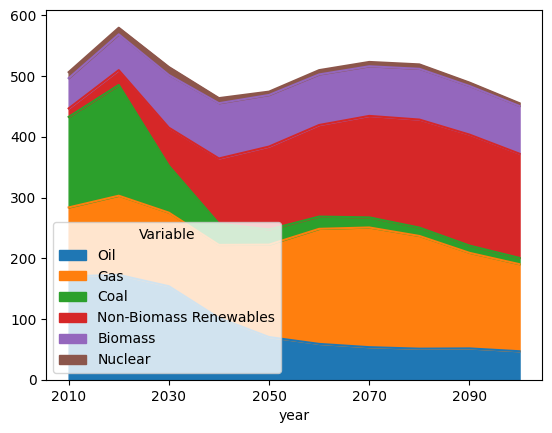

In [36]:
getrun(1).loc[['Oil','Gas','Coal','Non-Biomass Renewables','Biomass','Nuclear']].T.plot.area()

#MultiVariate EOF - energy sectors


In [37]:
fields=['CCS','Oil','Coal','Gas','Land Use','CH4','AFOLU','Energy and Industrial Processes','N2O','Final Energy','Biomass','Non-Biomass Renewables','Nuclear']

In [38]:
#define normalisation of fields for PCA
fld_scl=[100,1,1,1,100,1,100,100,100,1,1,1,1]
eof_in=[]
for i,f in enumerate(fields):
  eof_in.append(tb[f].to_numpy()/fld_scl[i])



Make short titles for plots

In [39]:
def contains_multiple_words(s):
  return len(s.split()) > 1
fld_shrt=[]
for i,f in enumerate(fields):
  if shv[f].split('|')[0:][0]=='Emissions':
    dm='em_'
  else:
    dm=''
  if contains_multiple_words(f):
    fld_shrt.append(dm+''.join([x[0].upper() for x in f.split(' ')]))
  else:
    fld_shrt.append(dm+f)
fld_shrt

['CCS',
 'Oil',
 'Coal',
 'Gas',
 'LU',
 'em_CH4',
 'em_AFOLU',
 'em_EAIP',
 'em_N2O',
 'FE',
 'Biomass',
 'NR',
 'Nuclear']

#solve for EOFs

In [40]:
solver = MultivariateEof(eof_in, center=True)

In [41]:
fcdr=np.sign(solver.eofs()[0][:,5])

Plot first n EOFs for each component in multi-variate set

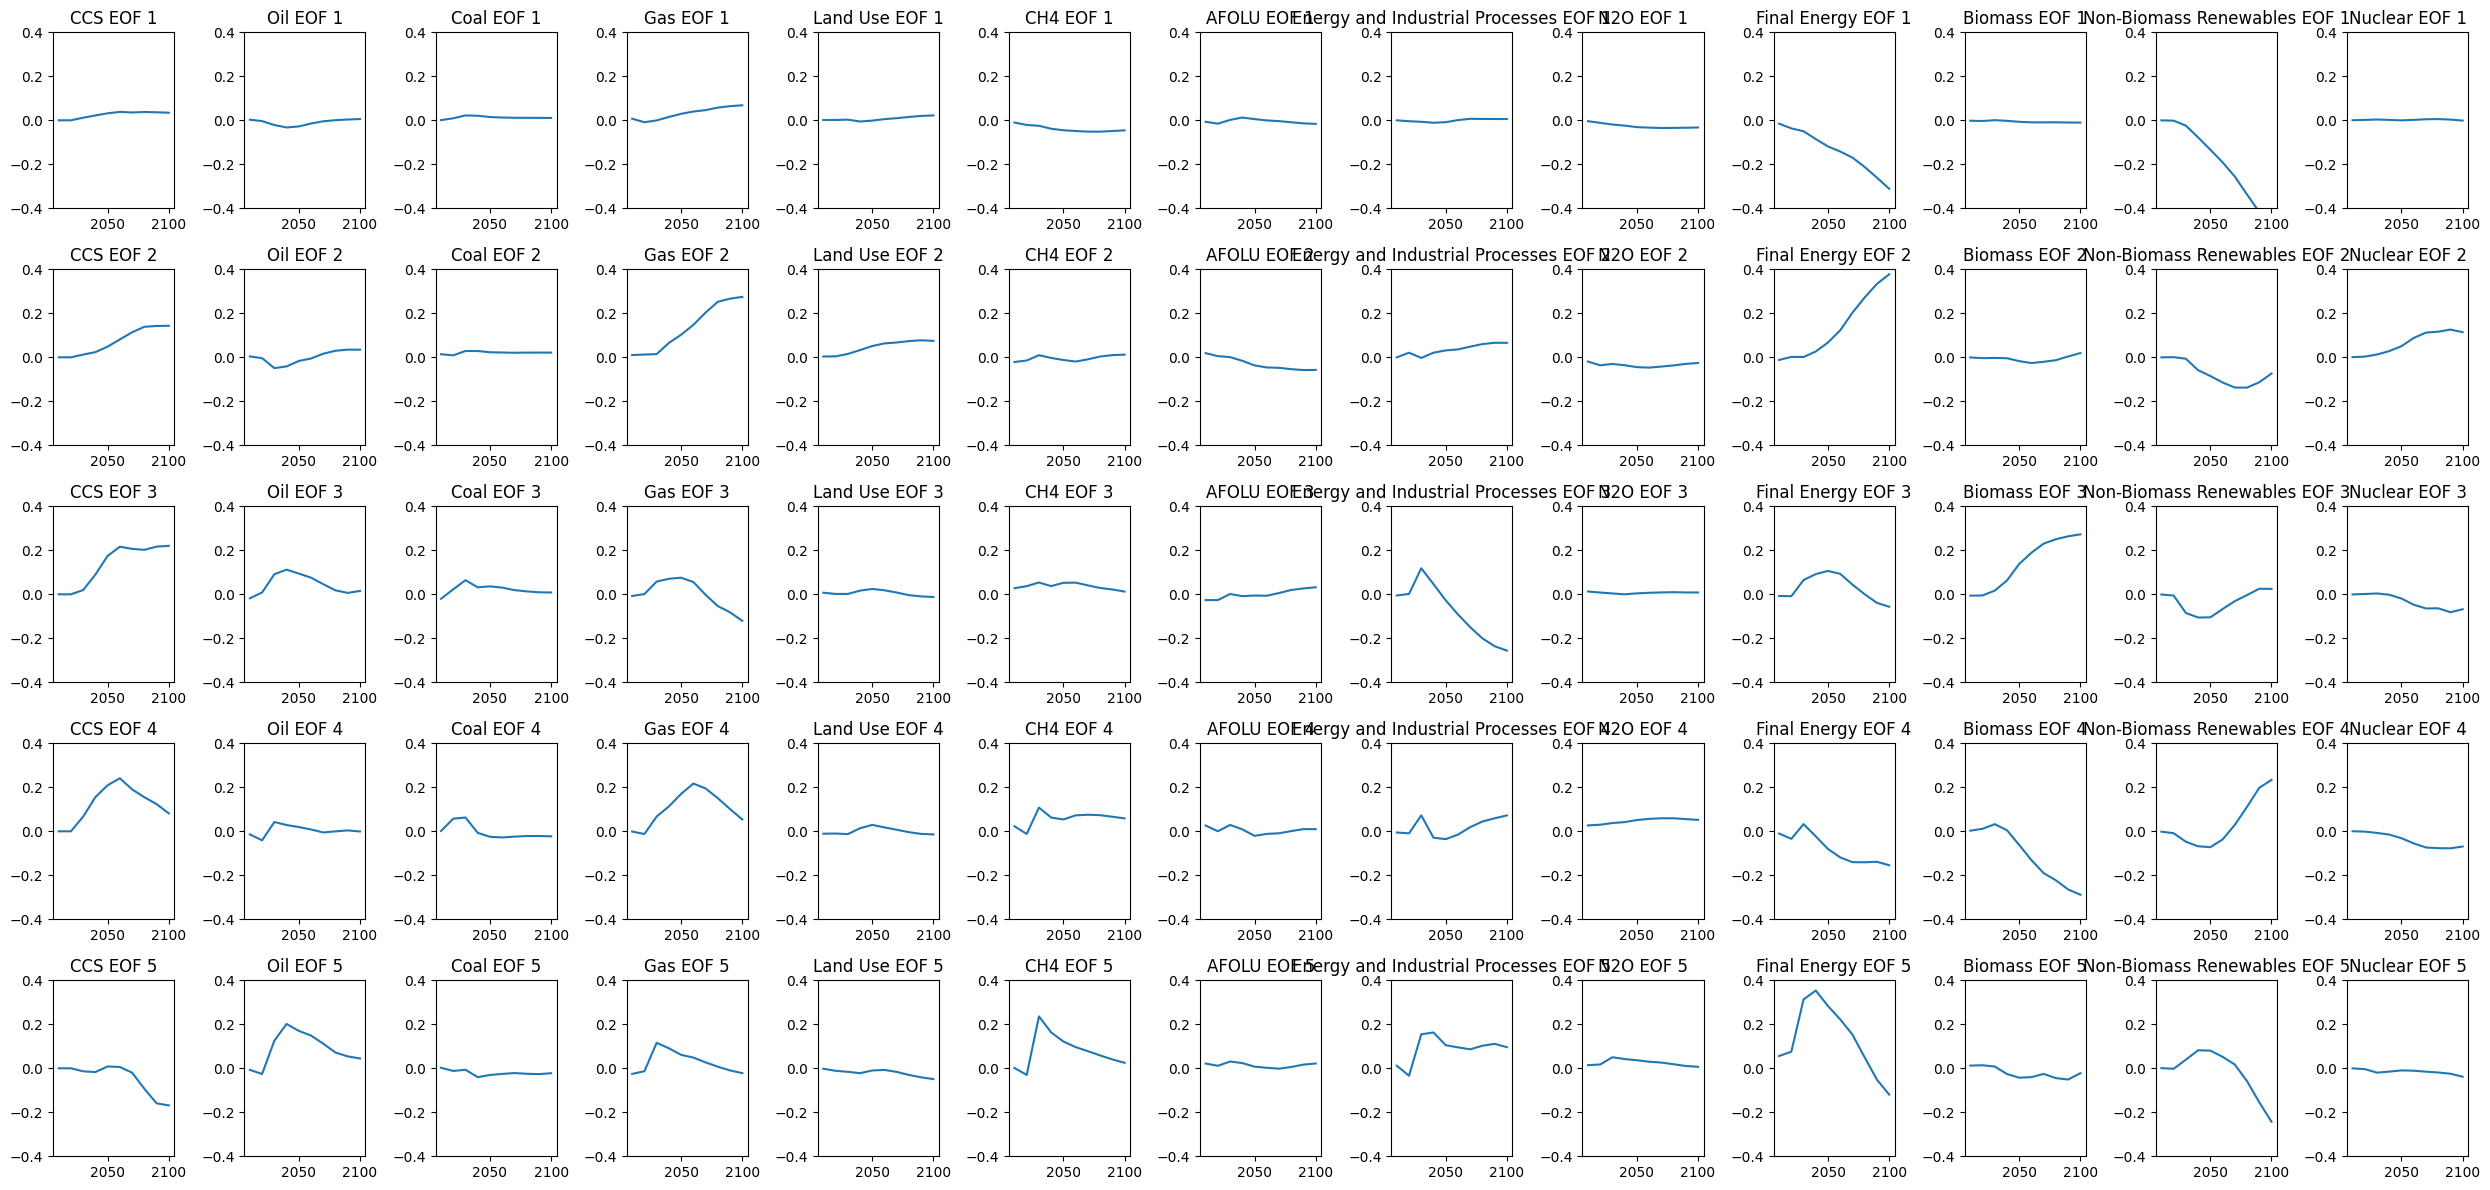

In [42]:

fig, ax = plt.subplots(nrows=5, ncols=len(fld_scl),figsize=(25,12))
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        col.plot(years,fcdr[i]*solver.eofs()[j][i,:])
        col.set_title(fields[j]+' EOF '+str(i+1))
        col.set_ylim(-0.4,0.4)
fig.tight_layout()

Pair plot to show distribution of scenarios in EOF space

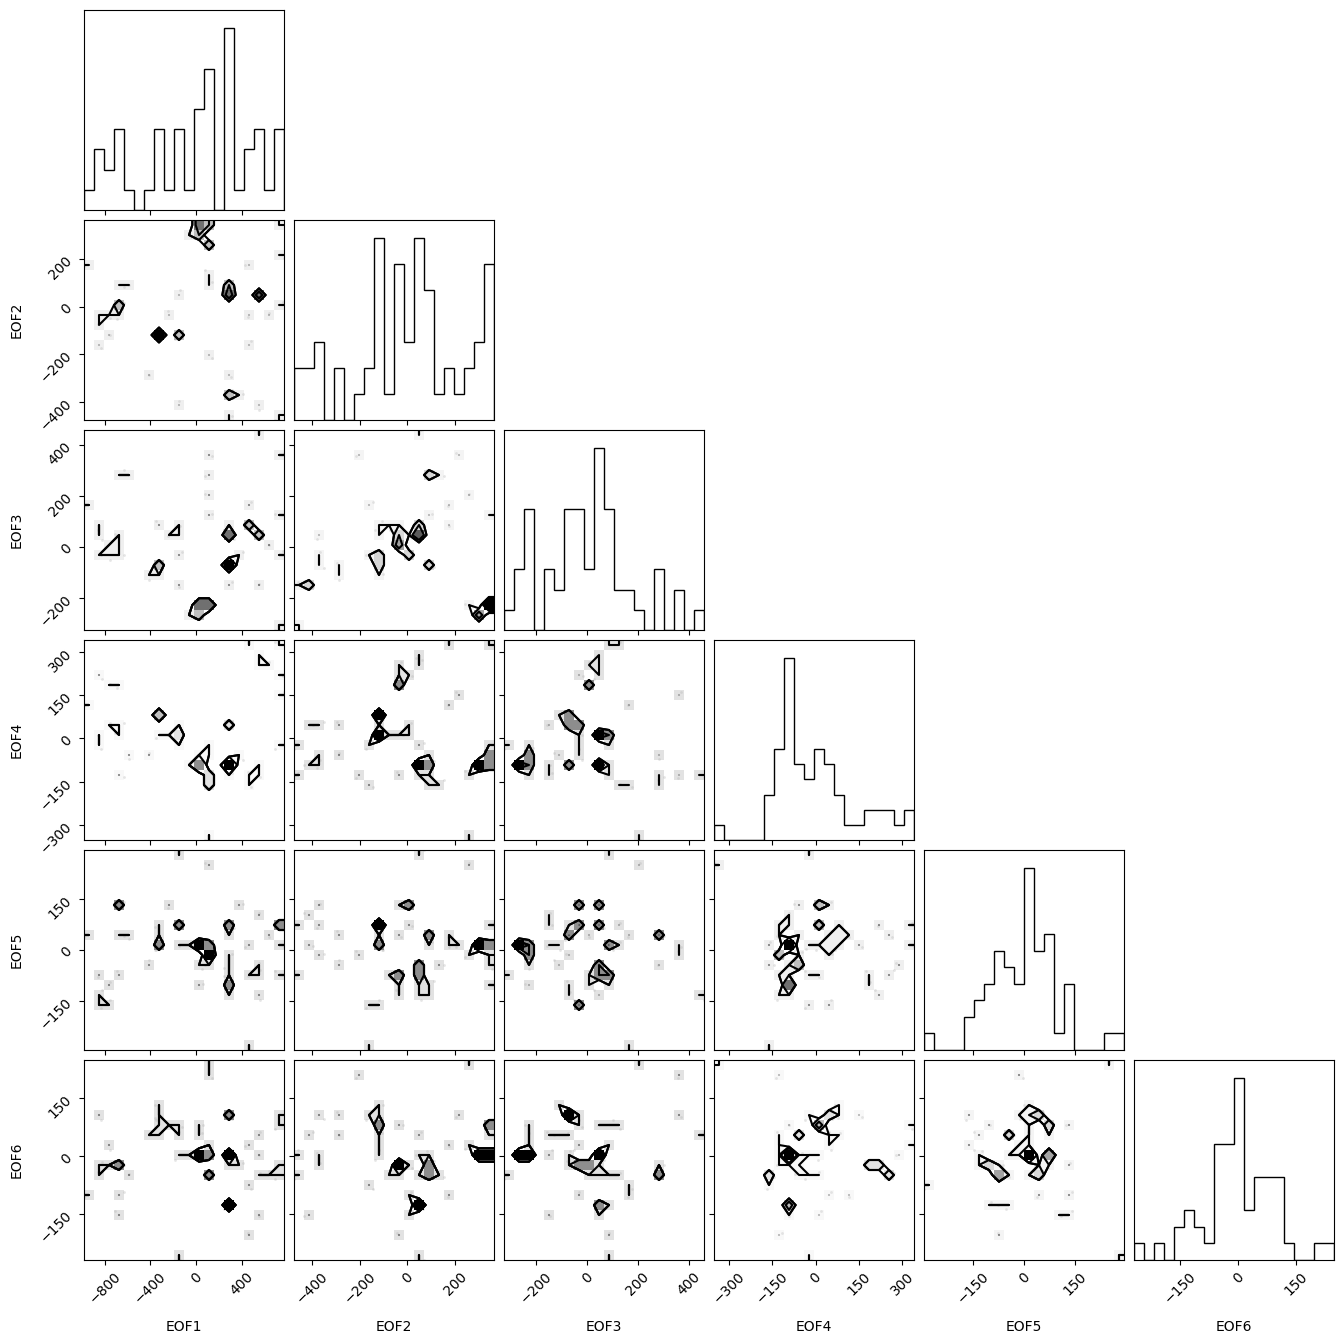

In [43]:
pcs=np.matmul(solver.pcs(npcs=6),np.diag(fcdr[0:6]))
figure = corner.corner(pcs,labels=["EOF1","EOF2","EOF3","EOF4","EOF5","EOF6"],hist2d_kwargs={"plot_datapoints": True,"plot_density": False, "plot_contours":False})

Plot scenario timeseries, colored according to whether they are high/low in each EOF

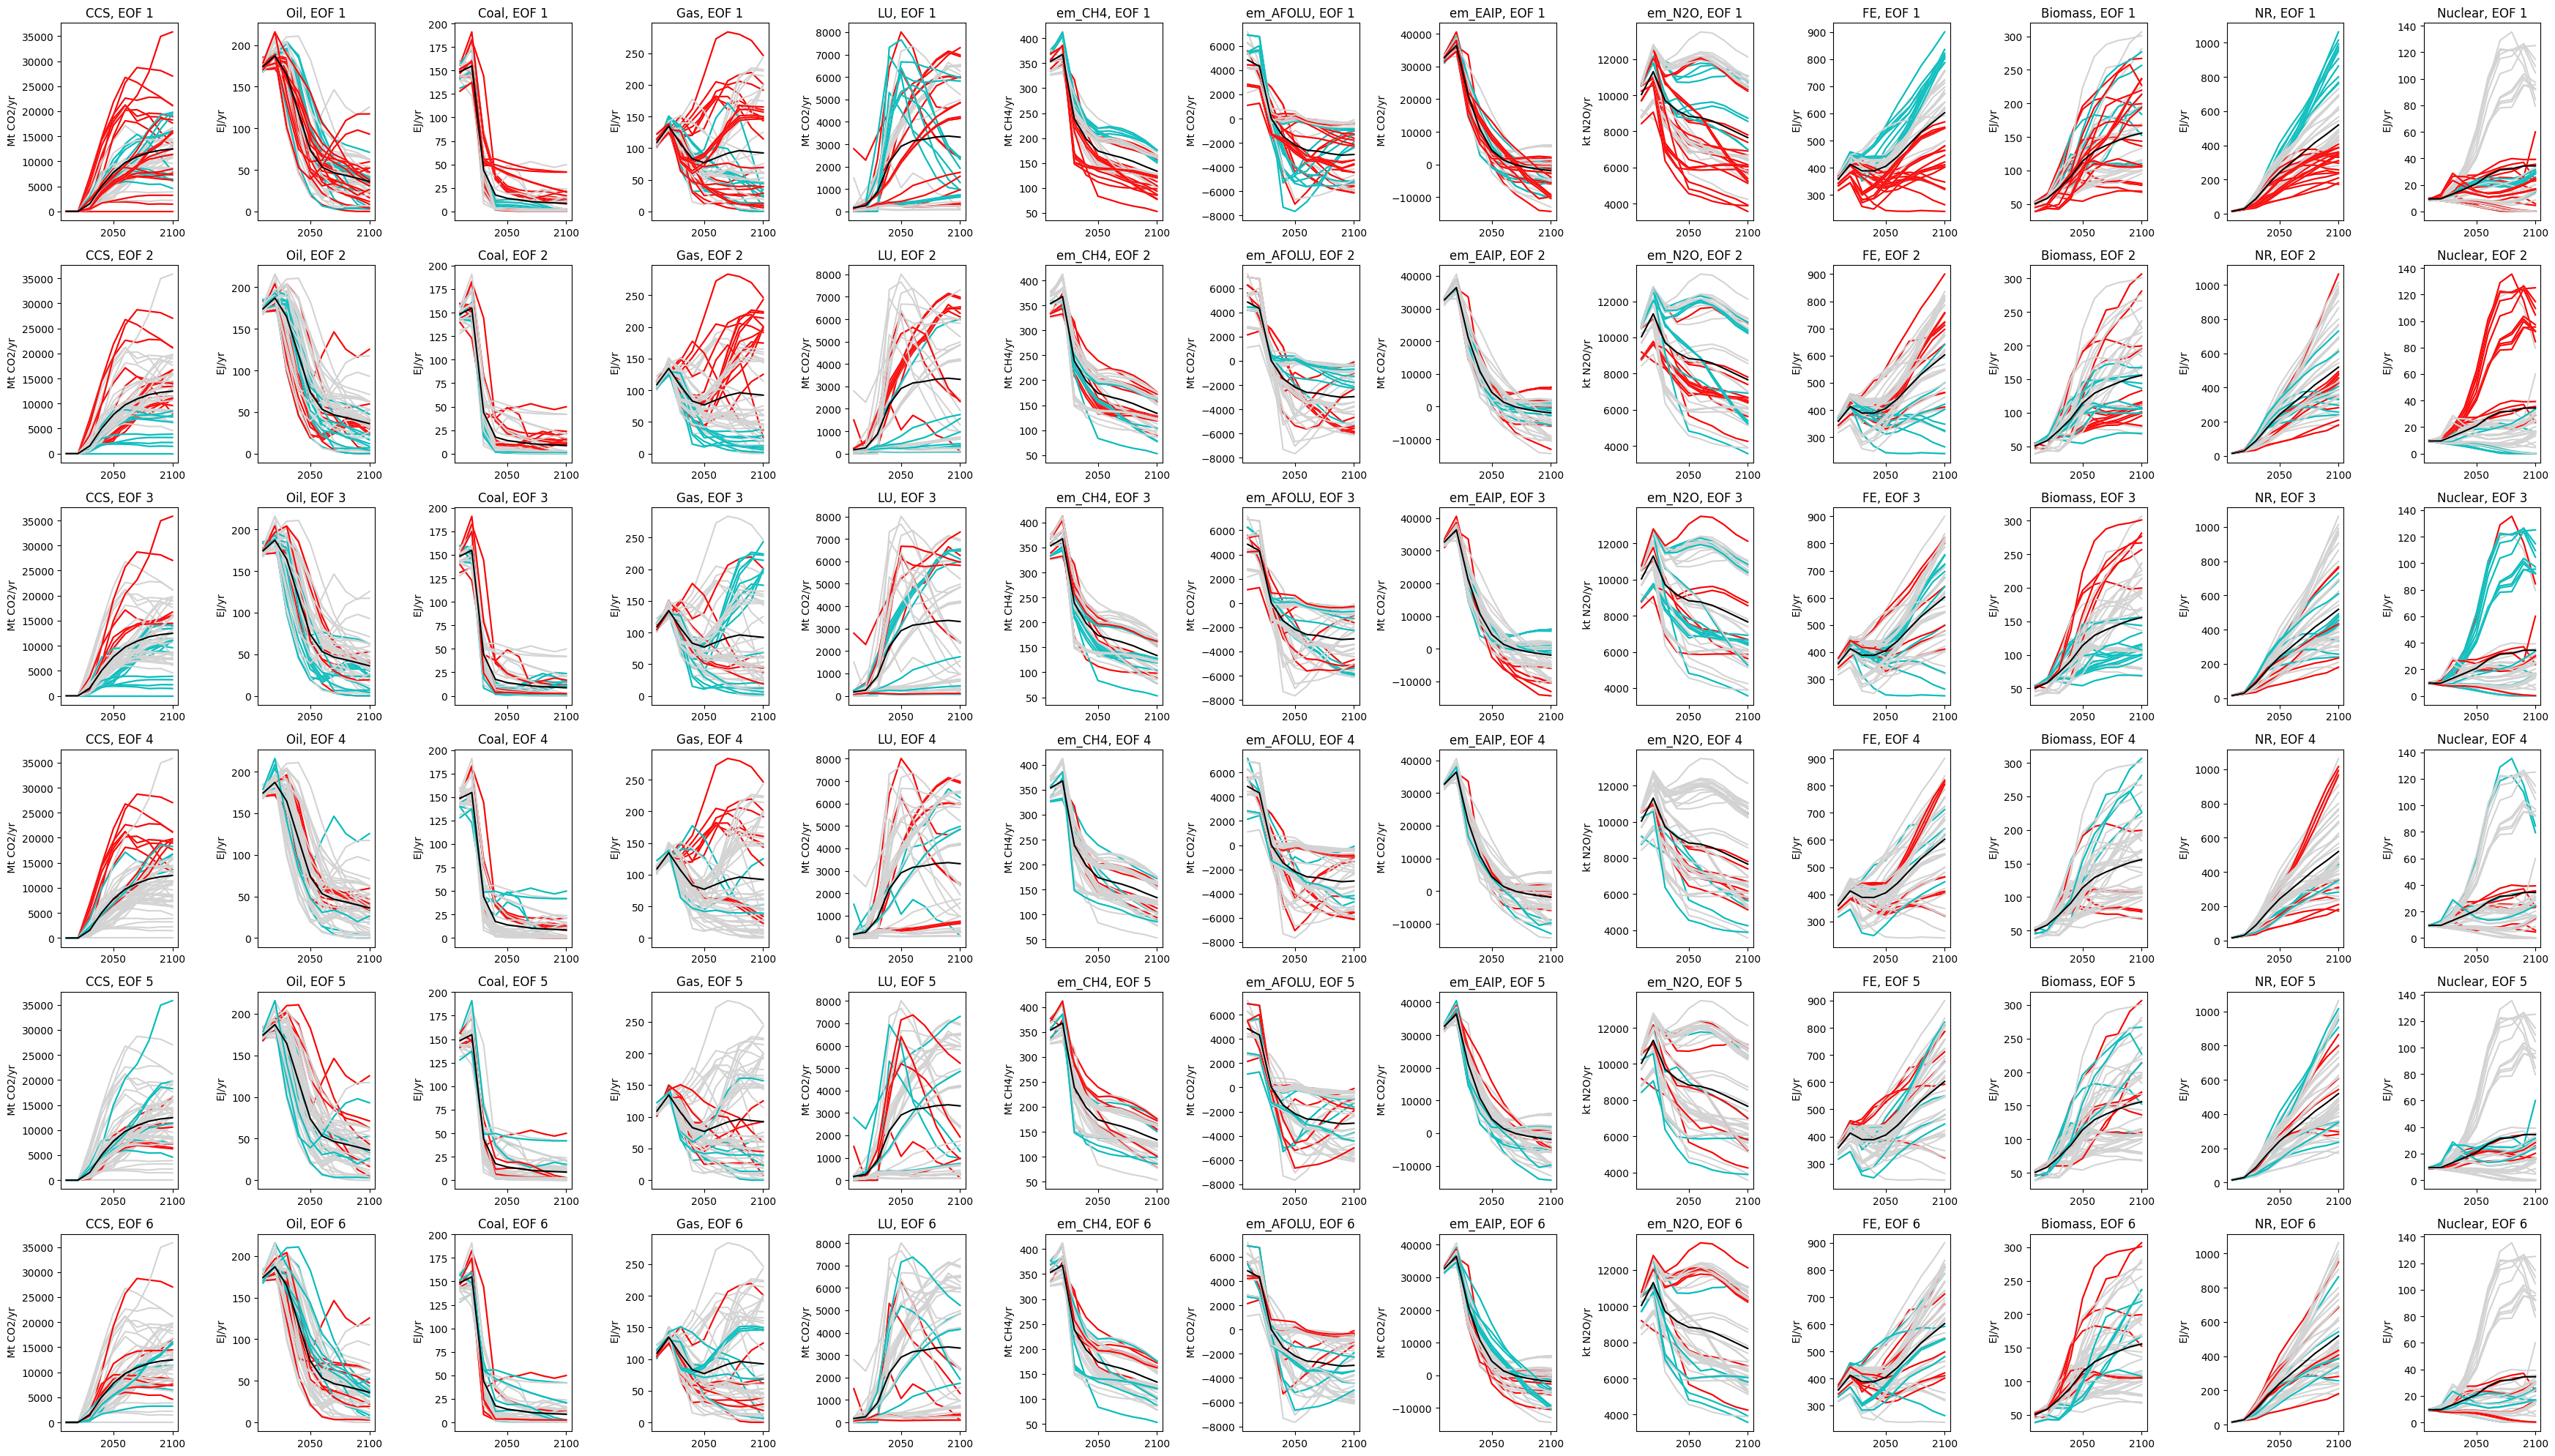

In [44]:
fig, ax = plt.subplots(nrows=6, ncols=len(fld_scl),figsize=(35,20))
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        for k in range(tb[fields[j]].T.shape[1]):
          x=pcs[:,i]
          nx = (x-min(x))/(max(x)-min(x))
        #col.plot(years,tb[fields[j]].iloc[k],color=[np.square(nx[k]),np.square((1-nx[k])),np.square((1-nx[k]))])
          col.plot(years,tb[fields[j]].iloc[k],color='lightgrey')
          if nx[k]>0.7:
            col.plot(years,tb[fields[j]].iloc[k],color='r')
          if nx[k]<0.3:
            col.plot(years,tb[fields[j]].iloc[k],color='c')
        col.plot(years,tb[fields[j]].mean(),color='k')
        col.set_ylabel(' '+tb[fields[j]].unit)
        col.set_title(fld_shrt[j]+', EOF '+str(i+1))
fig.tight_layout()








empirical descriptions for each EOF

In [45]:
EOF_desc=['Low Demand','Rapid CCS, high Nat. gas','Rapid CCS & Oil','Decrease coal & mitigate SLCF','Short term low demand','Rapid oil phaseout']

In [46]:
from itertools import groupby,islice
def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='gray')
    line.set_clip_on(False)
    ax.add_line(line)
def add_line1(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + 1, ypos],
                      transform=ax.transAxes, color='gray')
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]
    #return [(k, sum(1 for i in g)) for k,g in zip(labels)]

def label_group_bar_table(ax, df):
    ypos = -.1
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        pos = 0
        if level==1:
          for label in df.index.get_level_values(level):
            lxpos = (pos + 1)*scale
            ax.text(lxpos, ypos, label, ha='right', va='top' ,transform=ax.transAxes,rotation='vertical')
            add_line(ax, pos*scale, ypos)
            pos += 1
        else:
          for label, rpos in label_len(df.index,level):
            lxpos = (pos + 0.5 * rpos + 0.5)*scale
            ax.text(lxpos, ypos, label, ha='right', va='top' ,transform=ax.transAxes,rotation=30)
            add_line1(ax, pos*scale, ypos)
            pos += rpos
        add_line1(ax, pos*scale , ypos)
        ypos -= 1

<ipython-input-47-f11320588c7b>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("bwr",7)


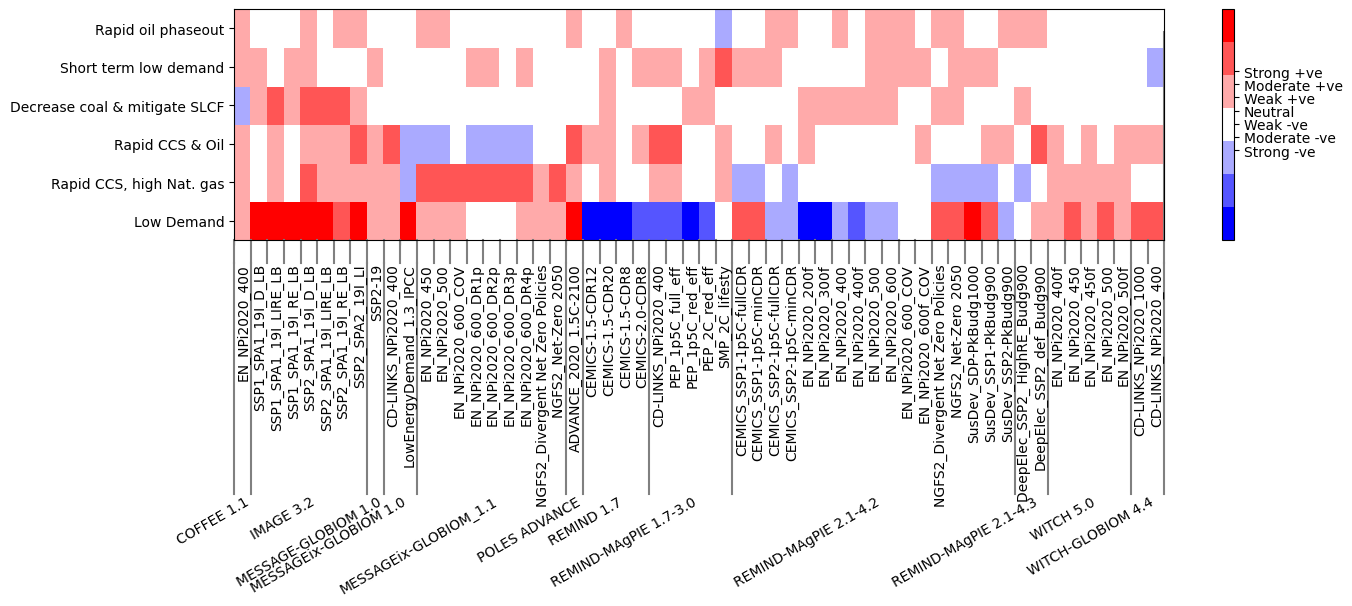

In [47]:
plt.figure(figsize=(15,3))

cmap = plt.cm.get_cmap("bwr",7)
plt.pcolor(pcs.T, cmap=cmap)
ax=plt.gca()
ax.set_yticks(np.arange(0.5,6))
ax.set_yticklabels(EOF_desc)
ax.set_xticklabels('')
ax.set_xlabel('')
label_group_bar_table(ax, tb['CCS'])
cb=plt.colorbar()
cb.set_ticks([-300,-200,-100,0,100,200,300])
cb.set_ticklabels(['Strong -ve','Moderate -ve','Weak -ve','Neutral','Weak +ve','Moderate +ve','Strong +ve'])